# Google trends data exploration

In [47]:
import pandas as pd
import numpy as np
import scipy as sp

from pytrends.request import TrendReq

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import deque
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [31]:
pytrends = TrendReq(hl='en-US', tz=360)

### Setup a payload for 'Gas prices' in the US 

In [32]:
keyword = "Gas prices"
kw_list = [keyword]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [33]:
# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

# TODO: List some major economic events in the U.S.
# Can even look at data by state - geo = 'US-WA' for example. can do a map visualization over time of state relative queries.

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,10,False
2004-04-01,11,False
2004-05-01,32,False


#### What do the numbers represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [34]:
has_null = any(interest_df[keyword].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
assert not has_null

### Check that there is consistent time granularity between rows

In [7]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 30 days 00:00:00


### Describe data

In [8]:
interest_df.describe()

,Gas prices
count,185.000000
mean,13.632432
std,11.255193
min,5.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,100.000000


## Trend visualization for keywords

## Using related queries as feedback to get more results

In [5]:
def get_related_for_keyword(kw):
    kw_list = [kw]
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
    interest_df = pytrends.interest_over_time()
    return pytrends.related_queries()

In [66]:
# Modify these to grow the size of the tree and to choose a different starting keyword
start_kw = 'Gas prices'
num_iters = 5
k = 3 # Top-k related keywords to find per word


graph_dict = {}
q = deque()
q.append(start_kw)

for i in range(num_iters):
    # get the next keyword
    kw = q.popleft()
    print("Finding related terms to {}...".format(kw))
    
    # Get related keywords for given keyword
    related = get_related_for_keyword(kw)

    # Get the top k related keywords
    top_k = list(related[kw]['top'][:k]['query'].values)
    
    # Add to graph data dict
    if kw not in graph_dict:
        graph_dict[kw] = []
    graph_dict[kw] = top_k
    
    q.extend(top_k)
print("Done")

Finding related terms to Gas prices...
Finding related terms to gas price...
Finding related terms to gas prices near me...
Finding related terms to natural gas prices...
Finding related terms to price of gas...
Done


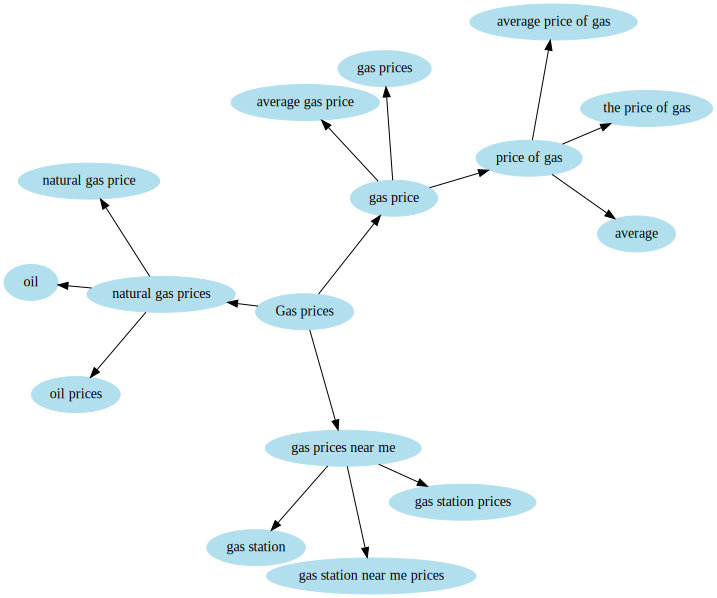

In [67]:
dot = Digraph(engine='neato')
dot.node_attr.update(color='lightblue2', style='filled')
dot.edge_attr.update(len='1.6')

for kw in graph_dict:
    dot.node(kw, kw)
    for child in graph_dict[kw]:
        dot.node(child, child)
        dot.edge(kw, child, length='1')
#dot.render('test', view=True, cleanup=True)
dot

## Manual parameter selection ARIMA

### Order of differencing (D)

In [35]:
interest_df.head()

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,10,False
2004-04-01,11,False
2004-05-01,32,False


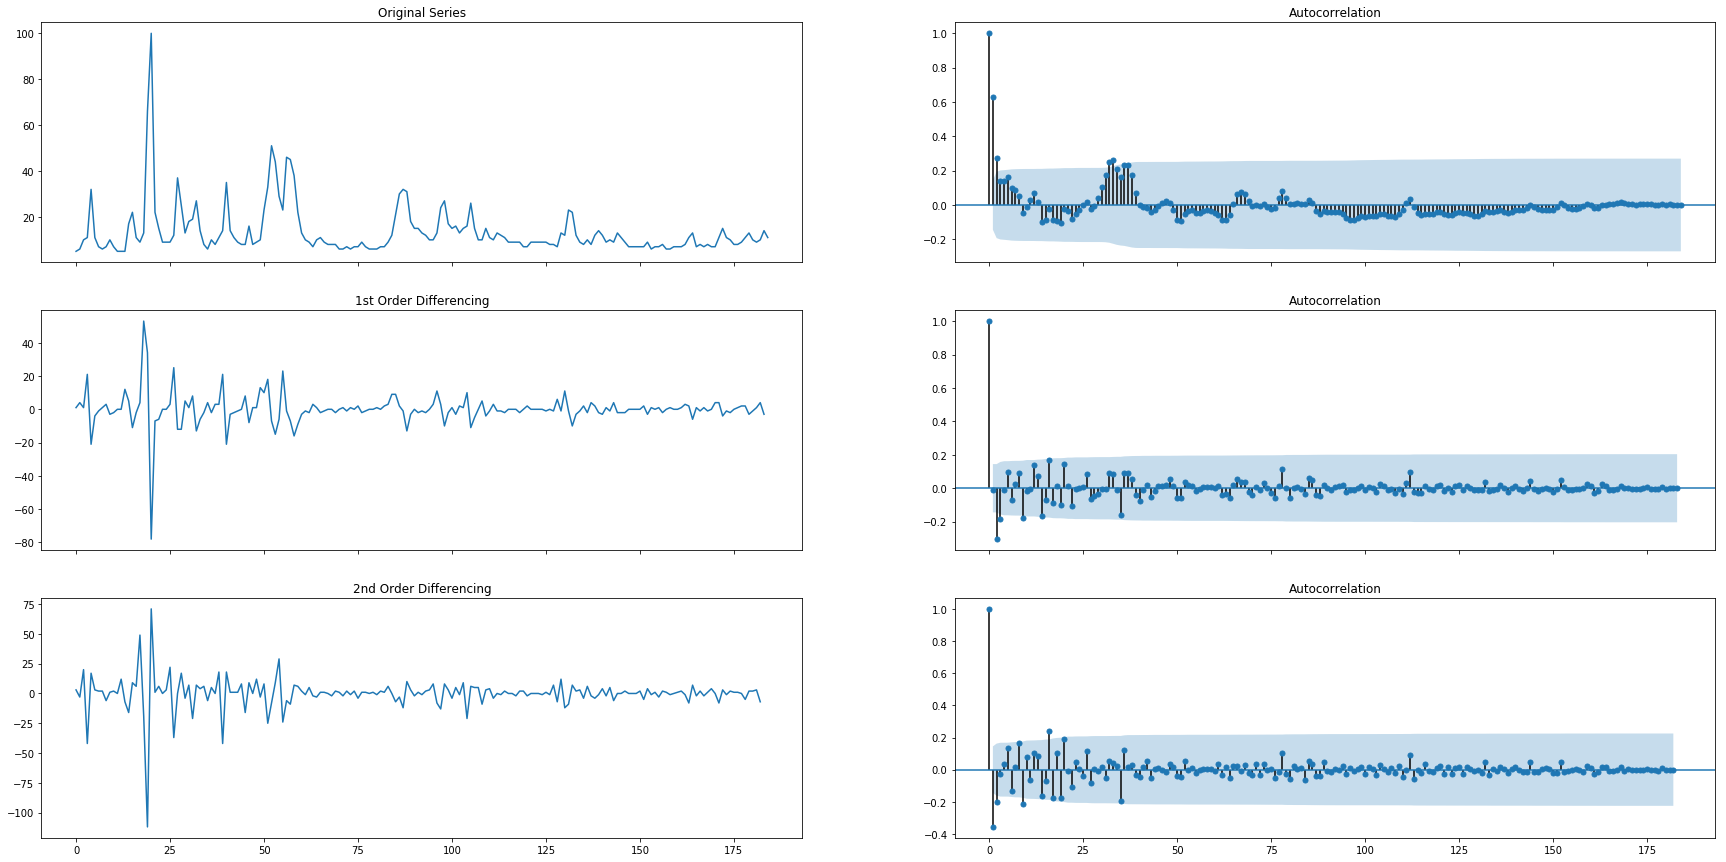

In [41]:
kw = 'Gas prices'
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(interest_df[kw].values); axes[0, 0].set_title('Original Series')
plot_acf(interest_df[kw].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(interest_df[kw].values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(interest_df[kw].values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(interest_df[kw].values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(interest_df[kw].values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [48]:
adf_dif0 = adfuller(interest_df[kw].values)
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(interest_df[kw], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(interest_df[kw], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: -5.616092 p-value: 0.000001
ADF Statistic: -6.867359 p-value: 0.000000
ADF Statistic: -7.497132 p-value: 0.000000


/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 184, using nperseg = 184
  .format(nperseg, input_length))


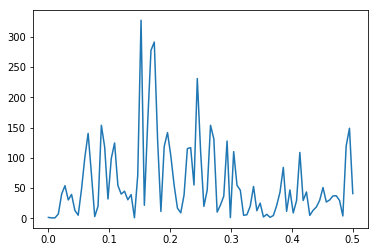

In [50]:
freqs, pw = sp.signal.welch(np.diff(interest_df[kw].values))
plt.plot(freqs, pw)

We do an ad-fuller test to determine whether the series is stationary, based on above, 1st order differencing is more than enough.

### Number of lags in the AR model (p)

We plot the PACF of the 1st-differenced prices to see how well lagged observations explain variations in the data

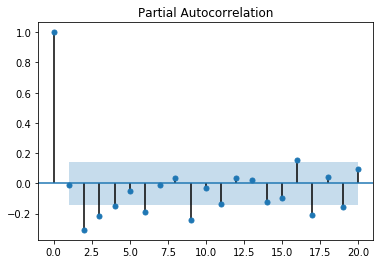

In [56]:
plot_pacf(np.diff(interest_df[kw].values, axis = 0), lags = 20);

??? Which values are well above the confidence interval?

We plot ACF to see how well lagged errors explain variations in the data

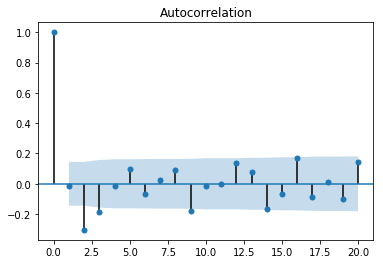

In [58]:
plot_acf(np.diff(interest_df[kw], axis = 0), lags = 20);

## Model Fitting

In [61]:
order = np.array([2,1,1])
model = ARIMA(interest_df[kw], order=order)
model_fit = model.fit()
print(model_fit.summary())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Gas prices   No. Observations:                  184
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -654.542
Method:                       css-mle   S.D. of innovations              8.386
Date:                Sun, 26 May 2019   AIC                           1319.083
Time:                        13:05:53   BIC                           1335.158
Sample:                    02-01-2004   HQIC                          1325.599
                         - 05-01-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0538      0.024     -2.260      0.025      -0.100      -0.007
ar.L1.D.Gas prices     0.7456      0.072     10.398      0.000       0.605       0.886
ar.L2.D.Gas prices  

                0
count  184.000000
mean     0.498045
std      8.579000
min    -46.923893
25%     -2.833841
50%     -1.250106
75%      1.608534
max     53.592158


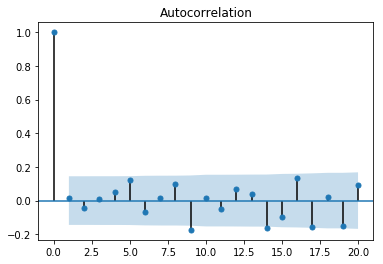

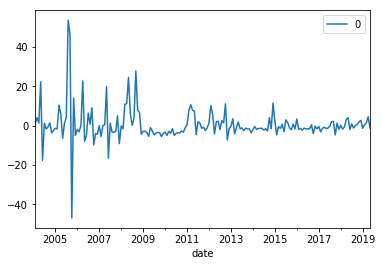

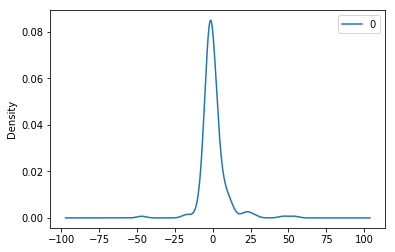

In [62]:
residuals = pd.DataFrame(model_fit.resid)
plot_acf(residuals, lags = 20);
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


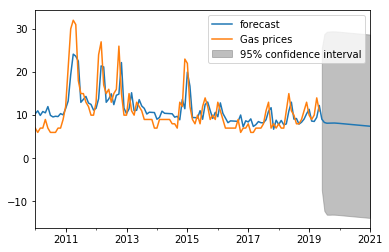

In [63]:
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()